In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
from config import load_config
paths = load_config(dataset_key='all')

Paths are for dataset tagged: all


In [2]:
f = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','r')
time = f['Time']
wavelength = f['Wavelength']
laser_order = f['Lasers']
channel_1 = f['Channel1']
channel_2 = f['Channel2']
channel_3 = f['Channel3']
channel_4 = f['Channel4']
channel_5 = f['Channel5']
channel_rawdata = np.zeros([channel_1.shape[0],channel_1.shape[1],5])
channel_rawdata[:,:,0] = channel_1
channel_rawdata[:,:,1] = channel_2
channel_rawdata[:,:,2] = channel_3
channel_rawdata[:,:,3] = channel_4
channel_rawdata[:,:,4] = channel_5

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\AIND\output_data\BigTiffs2023-08-10T10_18_19.7043072-07_00\data_preprocessed.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

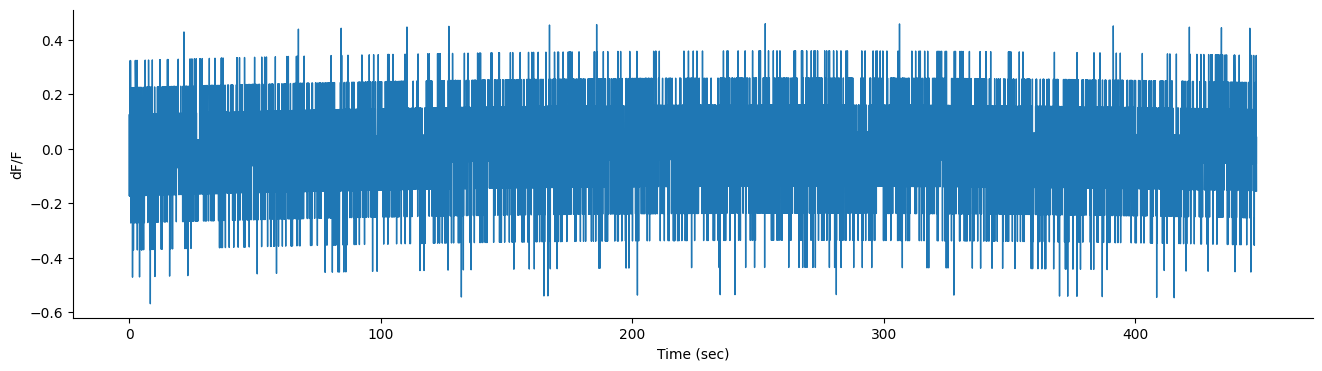

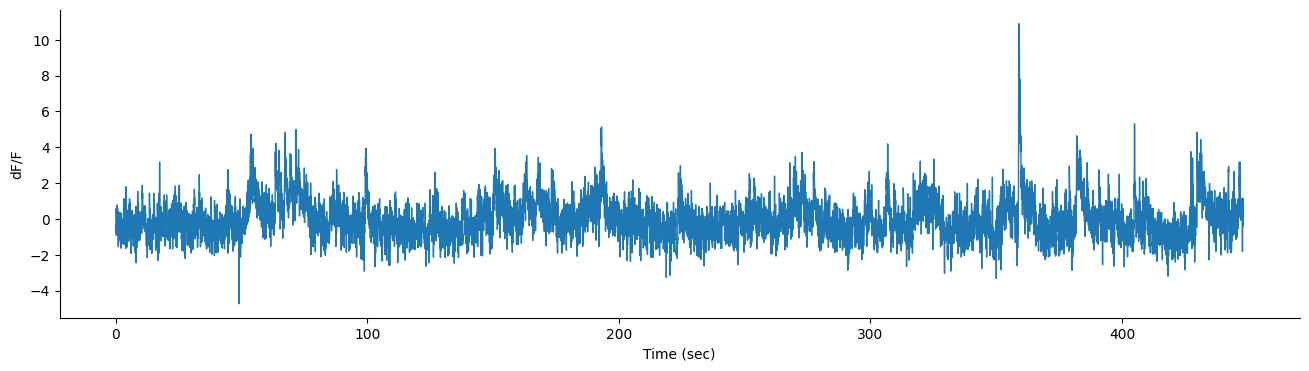

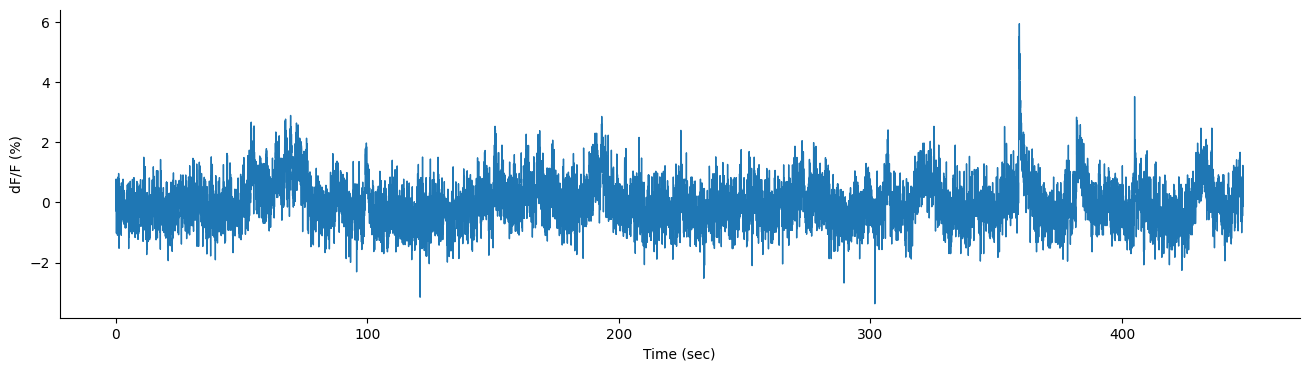

In [6]:
# Detrend the data with a second order polynomial and calculate df/f

ch_sig = np.zeros([channel_1.shape[0],channel_1.shape[1],5])
for ch in range(0,laser_order.shape[0]):
    for w in wavelength:
        cff_ch = np.polyfit(time,channel_rawdata[:,w-400,ch], deg=2)
        ch_fit = np.polyval(cff_ch, time)
        ch_sig[:,w-400,ch] = channel_rawdata[:,w-400,ch] - ch_fit + np.mean(channel_rawdata[:,w-400,ch])

ch_sig = ndimage.uniform_filter1d(ch_sig, size=10, axis=1)
ch_dff = 100*((ch_sig-np.mean(ch_sig, axis=0))/np.mean(ch_sig, axis=0))
ch_dff.shape

f,ax = plt.subplots(figsize=(16,4))
ax.plot(time[:], ch_dff[:,500-400,1], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f,ax = plt.subplots(figsize=(16,4))
ax.plot(time[:], ch_dff[:,540-400,4], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f,ax = plt.subplots(figsize=(16,4))
ax.plot(time[:], ch_dff[:,605-400,0], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


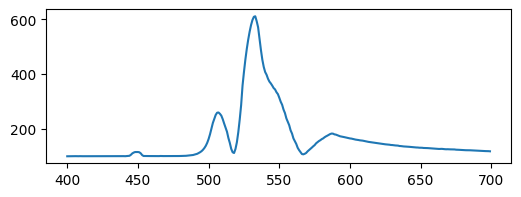

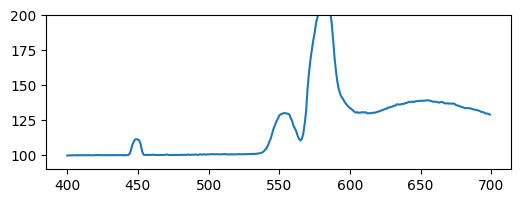

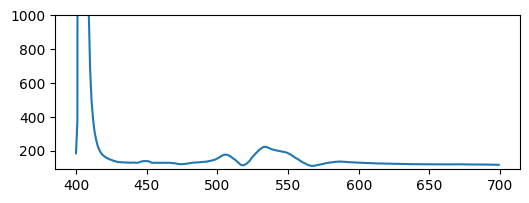

In [7]:
# Get spectra at each channel for visualizations
spectra = np.mean(channel_rawdata,axis=0)

f,ax = plt.subplots(figsize=(6,2))
ax.plot(np.transpose(wavelength),spectra[:,0])
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(np.transpose(wavelength),spectra[:,1])
ax.set_ylim(90,200)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(np.transpose(wavelength),spectra[:,3])
ax.set_ylim(90,1000)
plt.show()

In [8]:
# Save data for visualizations

data_preprocessed_view = {'Time':time, 'Wavelength':wavelength, 'Lasers':laser_order, 'Spectra':spectra, 'Channel_raw':channel_rawdata, 'Channel_dff':ch_dff}
for key in data_preprocessed_view.keys():
    print(f'\n{key}')
    print(data_preprocessed_view[key])
    
hf = h5py.File(paths['raw_data'] / 'data_preprocessed_view.hdf5','a')
for key in data_preprocessed_view.keys():
    hf.create_dataset(key, data = data_preprocessed_view[key])
hf.close()


Time
<HDF5 dataset "Time": shape (10752,), type "<f8">

Wavelength
<HDF5 dataset "Wavelength": shape (300,), type "<i4">

Lasers
<HDF5 dataset "Lasers": shape (5,), type "<i4">

Spectra
[[   99.91694568    99.83826265    99.6749442    184.35416667
    102.01134673]
 [  100.00995164    99.94726562    99.79724702   376.78320312
    103.25437128]
 [   99.97014509    99.86728051    99.68452381 12049.47107515
    104.84756324]
 ...
 [  118.73995536   129.80961682   110.30375744   116.89676339
    140.09468006]
 [  118.59384301   129.61309524   110.2734375    116.76078869
    139.73316592]
 [  118.11458333   129.06194196   109.88411458   116.3016183
    139.07626488]]

Channel_raw
[[[  100.   100.   100.   186.   102.]
  [  100.   100.   100.   378.   103.]
  [  100.   100.    99. 12051.   105.]
  ...
  [  118.   129.   110.   117.   142.]
  [  118.   130.   111.   116.   139.]
  [  118.   129.   110.   117.   141.]]

 [[   99.   100.    99.   185.   102.]
  [  100.   100.   100.   376.   1

In [9]:
# Remove laser noise from signal

t = np.array(time)
freq = 1/np.diff(t)
samp_fs = np.round(np.median(freq))
noise = np.mean(ch1_dff[:,80:83], axis=1)
print(noise.shape)

from scipy.sparse.linalg import lsqr
print(np.reshape(ch1_dff[:,140],(3127,1)).shape)
result = lsqr(np.reshape(ch1_dff[:,140],(3127,1)),np.reshape(noise,(3127,1)))
print(result)
sc_noise = noise/result[0]
y = ch1_dff[:,140]-sc_noise

xlim=[300,400]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], ch1_dff[:,140], linewidth=1)
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='signal and scaled noise',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='noise',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='denoised',xlim=xlim)
plt.show()

NameError: name 'ch1_dff' is not defined

In [ ]:
# Highpass and lowpass filter and then remove noise

t = np.array(time)
freq = 1/np.diff(t)
samp_fs = np.round(np.median(freq))
noise = np.mean(ch1_dff[:,80:85], axis=1)
print(noise.shape)

highpass = 0.5
b,a = signal.butter(1,highpass,'highpass', fs=samp_fs)
sig_filt = signal.filtfilt(b,a,ch1_dff[:,140],axis=0)
noise_filt = signal.filtfilt(b,a,noise,axis=0)
print(noise_filt.shape)
result = lsqr(np.reshape(sig_filt,(3127,1)),np.reshape(noise_filt,(3127,1)))
print(result)
sc_noise = noise_filt*result[0]
y1 = sig_filt-sc_noise

xlim=[250,350]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], noise_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y1, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

In [ ]:
lowpass = 0.5
b,a = signal.butter(1,highpass,'lowpass', fs=samp_fs)
sig_filt = signal.filtfilt(b,a,ch1_dff[:,140],axis=0)
noise_filt = signal.filtfilt(b,a,noise,axis=0)
print(noise_filt.shape)
result = lsqr(np.reshape(sig_filt,(3127,1)),np.reshape(noise_filt,(3127,1)))
print(result)
sc_noise = noise_filt/result[0]
y2 = sig_filt-sc_noise

y = y1+y2

xlim=[250,350]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

# f,ax = plt.subplots(figsize=(6,2))
# ax.plot(time[:], noise_filt, linewidth=1)
# ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
# plt.show()
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y2, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], ch1_dff[:,140], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()